<a href="https://colab.research.google.com/github/ranaurek/Quantum-Graph-Coloring/blob/main/Grover's_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt
import time
import numpy as np
import networkx as nx

def setup(qc, a, b,c,d,output,anc1,anc2):
    qc.cx(a, anc1)
    qc.cx(c, anc1) # turn on anc1 if a and c are different
    
    qc.cx(b, anc2)
    qc.cx(d, anc2)  # turn on anc2 if b and d are different

def XOR(qc, a, b,c,d,output,anc1,anc2):
    
    qc.cx(anc1,output)   # turn on output if anc1 is on 
    qc.cx(anc2,output)   # turn on output if anc2 is on
    
    qc.ccx(anc1,anc2,output)    # turn on output if anc1 and anc2 is on (to correct possible mistake if both anc1 and anc2 were on originally)
    
    
def XOR2(qc, a, b,c,d,output,anc1,anc2):
    
    
        
    qc.ccx(anc1,anc2,output)
    
    qc.cx(anc1,output)
    qc.cx(anc2,output)
    
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

def sudoku_oracle(qc, clause_list, clause_qubits,anc,output_qubit):
    # Compute clauses
    i = 0
    for clause in clause_list:
        setup(qc, clause[0], clause[1],clause[2], clause[3], clause_qubits[i],anc[2*i],anc[2*i+1])
        XOR(qc, clause[0], clause[1],clause[2], clause[3], clause_qubits[i],anc[2*i],anc[2*i+1])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    #Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR2(qc, clause[0], clause[1],clause[2], clause[3], clause_qubits[i],anc[2*i],anc[2*i+1])
        i += 1

        
def genCircuit(clause_list,num_dif = 2):
    var_qubits = QuantumRegister(np.max(clause_list)+1, name='v')
    clause_qubits = QuantumRegister(len(clause_list), name='c')
    output_qubit = QuantumRegister(1, name='out')

    edges= QuantumRegister(len(clause_list)*2, name='anc')
    cbits = ClassicalRegister(np.max(clause_list)+1, name='cbits')
    qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit,edges,cbits)




    # Initialize 'out0' in state |->
    qc.initialize([1, -1]/np.sqrt(2), output_qubit)

    # Initialize qubits in state |s>
    qc.h(var_qubits)
    qc.barrier()  # for visual separation

    for i in range(0,num_dif):
        sudoku_oracle(qc, clause_list, clause_qubits,edges,output_qubit)
        qc.barrier()  # for visual separation
        # Apply our diffuser
        qc.append(diffuser(6), [0,1,2,3,4,5])

    # Measure the variable qubits
    qc.measure(var_qubits, cbits)
    
    return qc

(8,)


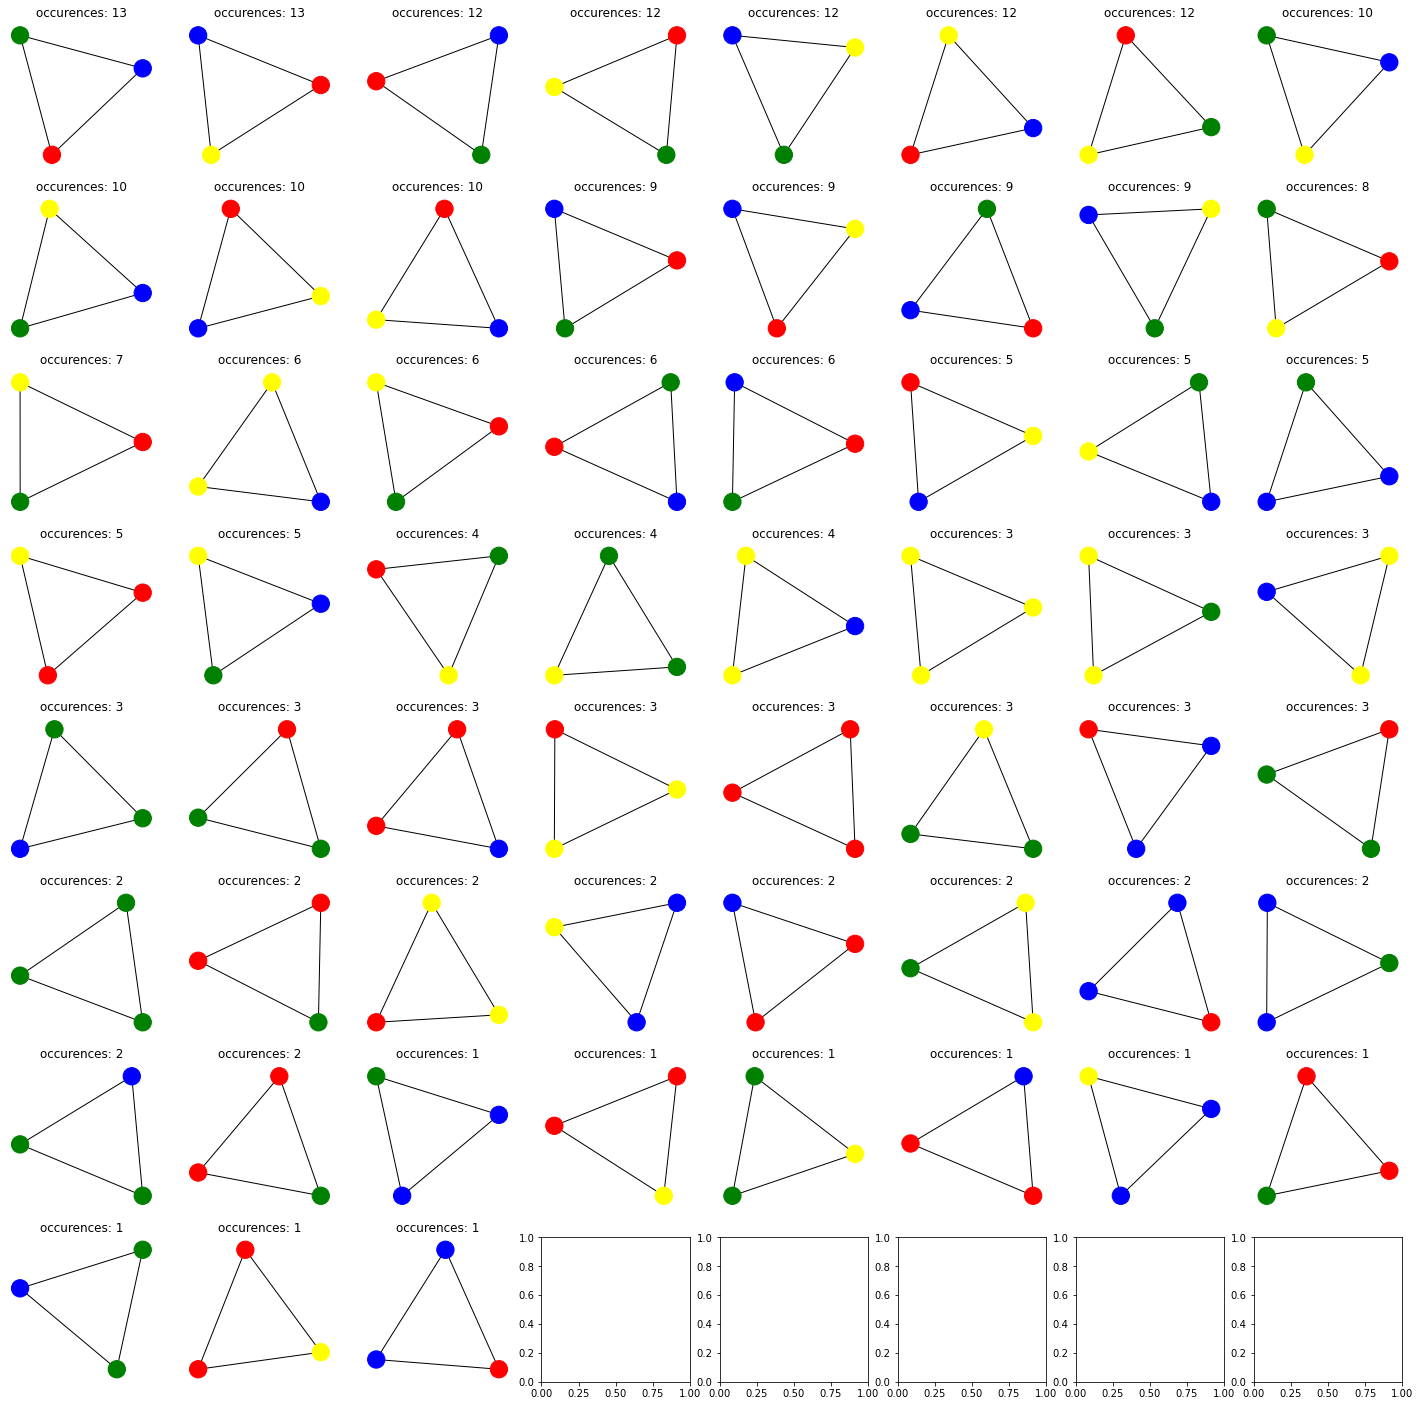

In [ ]:
def show_figure(fig):
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)


clause_list = [[0,1,2,3],[2,3,4,5],[0,1,4,5]]


from qiskit import IBMQ, Aer, assemble, transpile
from qiskit.visualization import plot_histogram

qc = genCircuit(clause_list,num_dif=2)
aer_sim = Aer.get_backend('aer_simulator')
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)


result = aer_sim.run(qobj,shots=300).result()

edges = set()

mx = 0;

for i in range(0,len(clause_list)):
    a = clause_list[i][1]//2
    b = clause_list[i][3]//2

    if(a<b):
        edges.add((a,b))

        if(b>mx):
            mx = b;
    else:
        edges.add((b,a))
        if(a>mx):
            mx = a

graph_size = mx


dic = {"00":"red","01":"green","10":"blue","11":"yellow"}
lst = []

res_unsorted = result.get_counts()

res = {k: v for k, v in sorted(res_unsorted.items(), key=lambda item: -item[1])}


fig, axs = plt.subplots(8, 8,figsize=(25,25) )


print(axs[0].shape)

error = 0
correct = 0 
gcounter = 0 ;
gcounter2 = 0;
for key in res:
    arr = []
    # print(res[key],end=" ")
    for i in range(0,3):
        nxt = dic[key[2*i:2*i+2]]
        # print(nxt,end=" ")
        arr.append(nxt)

    lst.append(arr)

    G = nx.Graph()
    for i in range(0,graph_size):
        G.add_node(i)

    G.add_edges_from(list(edges))

    nx.draw(G,node_color=arr,ax=axs[gcounter2][gcounter])
    axs[gcounter2][gcounter].set_title("occurences: "+str(res[key]))
    gcounter+=1;
    if(gcounter==8):
        gcounter2+=1;
        gcounter=0
# fig.show()
plt.show()